In [19]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from matplotlib import gridspec
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from matplotlib.ticker import MultipleLocator
import matplotlib as mpl
from cartopy.util import add_cyclic_point
from scipy import stats
import cmaps

In [32]:
def AreaWeightMean(data2D, lat, lon):
    '''
    data2D: 要进行区域加权平均的变量  2D: [lat, lon]
    lat: data2D对应的纬度 1D 最好不要包括-90° 和 90°  因为NCL 和 Python 计算 np.cos(90 * rad) 值差的很大 
    lon: data2D对应的经度 1D
    '''
    jlat = lat.shape[0]
    rad = 4.0 * np.arctan(1.0) / 180.0
    re = 6371220.0
    rr = re * rad
    dlon = np.abs(lon[2] - lon[1]) * rr
    dx = dlon * np.cos(lat * rad)
    dy = np.zeros(jlat)
    dy[0] = np.abs(lat[2] - lat[1]) * rr
    dy[1: jlat - 1]  = np.abs(lat[2: jlat]-lat[0: jlat - 2])*rr * 0.5
    dy[jlat - 1] = abs(lat[jlat - 1] - lat[jlat - 2]) * rr
    area = dx * dy
    # dataAreaWeightMean = np.sum(np.dot(area, data2D))/np.sum(area)
    sumtop = 0
    sumbottom = 0
    for id1 in range(data2D.shape[0]):
        for id2 in range(data2D.shape[1]):
            if(not np.isnan(data2D[id1, id2])):
                sumtop = sumtop + data2D[id1, id2]*area[id1]
                sumbottom = sumbottom +area[id1]
    dataAreaWeightMean = sumtop/sumbottom
    return dataAreaWeightMean



def group_year(data0, nyear):
    nmonth = 12
    data = np.zeros((nyear, nmonth, data0.shape[1], data0.shape[2]))
    for i in range(nyear):
        for j in range(nmonth):
            data[i, j, :, :] = data0[int(i*nmonth+j), :, :]
    return data



plt.style.use('default')
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.weight'] = 'bold'
mpl.rcParams['font.size']= 18

In [21]:
ds = xr.open_dataset('F:\\hwchen\\LUCC_exp\\out_LAI\\4-EM\\1960-2009_monmean_FC5_LUCC_dyn_3EM_TLAI.nc')
dsland = xr.open_dataset('F:\\hwchen\\pft_practice\\data\\surfdata.pftdyn_1.9x2.5_rcp4.5_simyr1850-2100_c110125.nc')
lai = ds['TLAI'].values
land = dsland['LANDFRAC_PFT'].values
lai_mean = np.mean(lai, axis=0)
lai_year_month = group_year(lai, 50)
lai_year = np.mean(lai_year_month, axis=1)
lai_diff = lai_year[49, :, :] - lai_year[0, :, :]
yr = np.arange(1960, 2010, 1)
b = lai_mean
for i in np.arange(lai_year.shape[1]):
    for j in np.arange(lai_year.shape[2]):
        b[i, j],_,_,_,_= stats.linregress(yr, lai_year[:, i, j])




lonL_EU, lonR_EU = -10, 60.
latS_EU, latN_EU = 45, 60.
lon, lat = ds['lon'].values, ds['lat'].values
logic = lon > 180
lon[logic] = lon[logic] - 360
logic1 = lon > lonL_EU
logic2 = lon < lonR_EU
logic3 = lat > latS_EU
logic4 = lat < latN_EU
logiclon = logic1
logiclat = logic3
for i in np.arange(logiclon.shape[0]):
    if(logic1[i] & logic2[i]):
        logiclon[i] = True
    else:
        logiclon[i] = False
for i in np.arange(logiclat.shape[0]):
    if(logic3[i] & logic4[i]):
        logiclat[i] = True
    else:
        logiclat[i] = False
lon = lon[logiclon]
lat = lat[logiclat]
lai_eu = lai_year[:, logiclat, :]
lai_eu = lai_eu[:, :, logiclon]
lai_eu_sum = np.zeros(lai_eu.shape[0])
for i in np.arange(lai_eu.shape[0]):
    lai_eu_sum[i] = AreaWeightMean(lai_eu[i, :, :], lat, lon)



lonL_EA, lonR_EA = 98, 122.
latS_EA, latN_EA = 10, 42.
lon, lat = ds['lon'].values, ds['lat'].values
logic = lon > 180
lon[logic] = lon[logic] - 360
logic1 = lon > lonL_EA
logic2 = lon < lonR_EA
logic3 = lat > latS_EA
logic4 = lat < latN_EA
logiclon = logic1
logiclat = logic3
for i in np.arange(logiclon.shape[0]):
    if(logic1[i] & logic2[i]):
        logiclon[i] = True
    else:
        logiclon[i] = False
for i in np.arange(logiclat.shape[0]):
    if(logic3[i] & logic4[i]):
        logiclat[i] = True
    else:
        logiclat[i] = False
lon = lon[logiclon]
lat = lat[logiclat]
lai_ea = lai_year[:, logiclat, :]
lai_ea = lai_ea[:, :, logiclon]
lai_ea_sum = np.zeros(lai_ea.shape[0])
for i in np.arange(lai_ea.shape[0]):
    lai_ea_sum[i] = AreaWeightMean(lai_ea[i, :, :], lat, lon)



lai_eu_ano = lai_eu_sum - np.mean(lai_eu_sum, axis=0)[np.newaxis, ...]
lai_ea_ano = lai_ea_sum - np.mean(lai_ea_sum, axis=0)[np.newaxis, ...]

Text(0.04, 0.1, 'b')

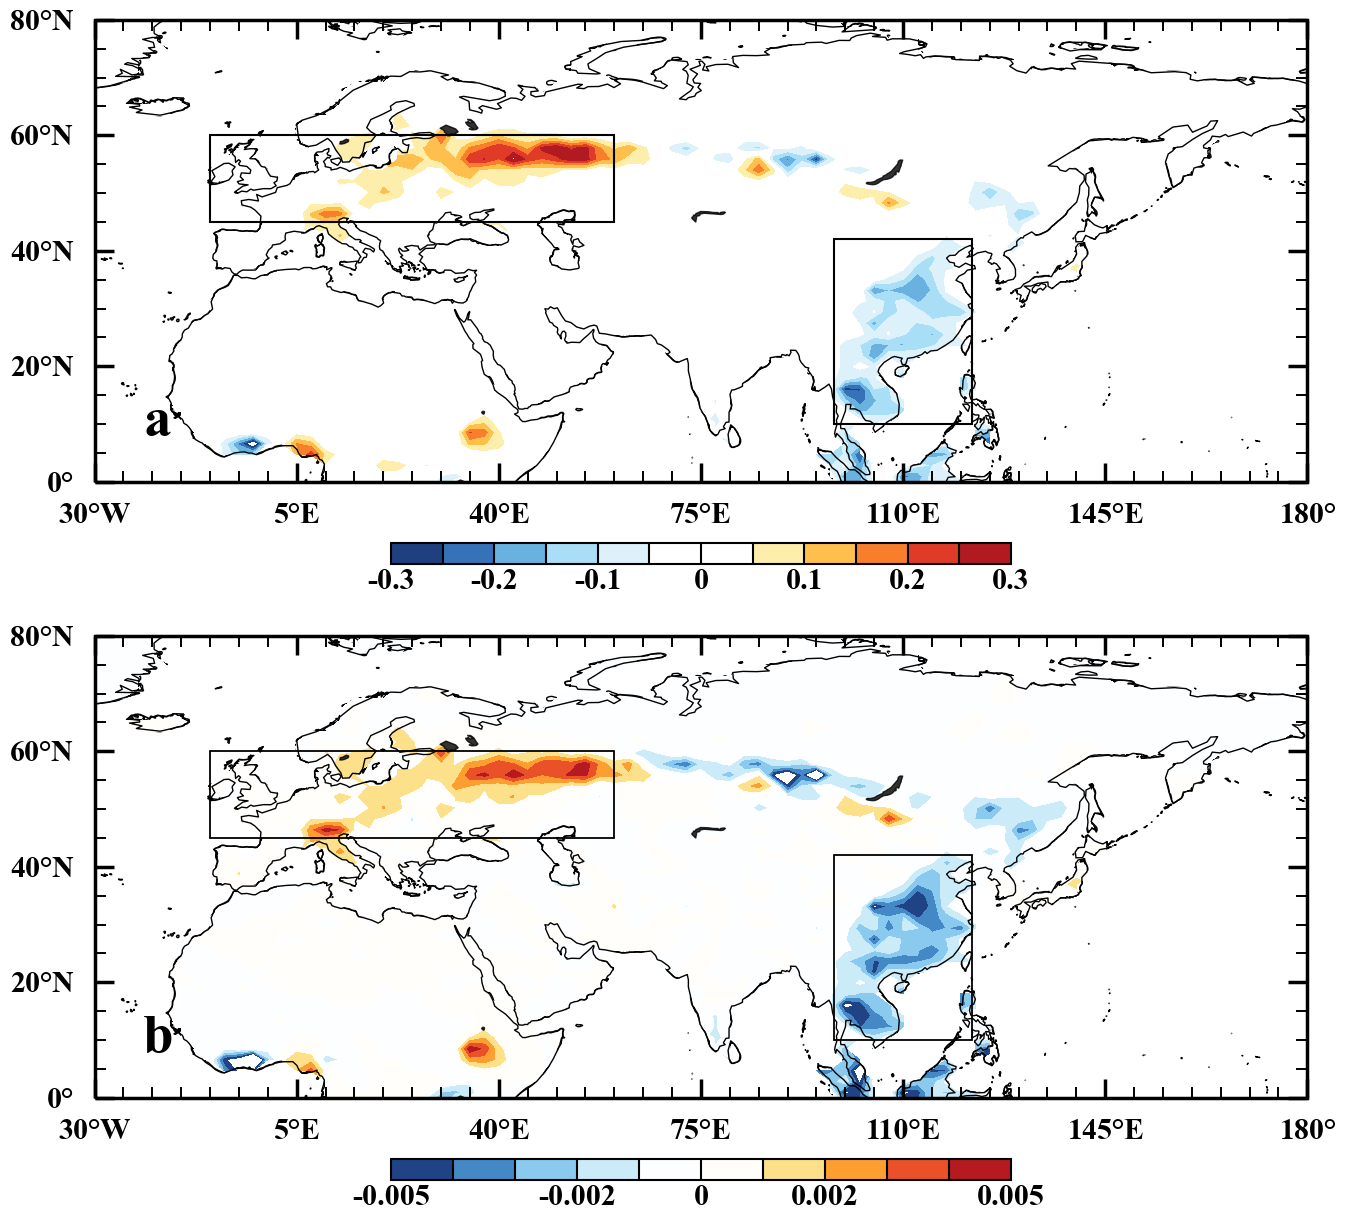

In [70]:
lonmin, lonmax = -30., 180.
latmin, latmax = 0., 80.
lon, lat = ds['lon'].values, ds['lat'].values
lai_mean_nan = np.where(land > 0.3, lai_diff, np.nan)
cycle_lai_mean, cycle_lon = add_cyclic_point(lai_mean_nan, coord=lon)
cycle_lon, cycle_lat = np.meshgrid(cycle_lon, lat)
fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(2, 1)
gs.update(wspace=0.26, hspace=0)
ax = fig.add_subplot(gs[0, 0], projection=ccrs.PlateCarree(central_longitude=80))
ax.set_extent([lonmin, lonmax, latmin, latmax], crs=ccrs.PlateCarree())
c1 = ax.contourf(cycle_lon, cycle_lat, cycle_lai_mean, cmap=cmaps.BlueWhiteOrangeRed, levels=np.arange(-0.3, 0.31, 0.05), transform=ccrs.PlateCarree())
cbar = fig.colorbar(c1, orientation='horizontal', shrink=0.5, pad=0.1, aspect=30, drawedges=True)
tick_locs=np.arange(-0.3, 0.31, 0.1)
tick_labels = ['-0.3','-0.2','-0.1','0','0.1','0.2','0.3']
cbar.set_ticks(ticks=tick_locs)
cbar.set_ticklabels(tick_labels)
cbar.dividers.set_linewidth(1.5)
cbar.outline.set_linewidth(1.5)
cbar.ax.tick_params(color='black', width=1.5, direction='out', length=0, labelsize='large')
ax.add_feature(cfeat.COASTLINE)
ax.add_feature(cfeat.LAKES, color='black', alpha=0.8)
ax.add_feature(cfeat.OCEAN.with_scale('50m'), lw=1, facecolor='white', edgecolor='black')
ax.set_xticks([-30, 5, 40, 75, 110, 145, 180], crs=ccrs.PlateCarree())
ax.set_yticks([0, 20, 40, 60, 80], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.tick_params(axis="both", which='major', width=2.5, length=14, direction='in', right=True, top=True, pad=15)
ax.tick_params(axis="both", which='minor', width=1.4, length=8, direction='in', right=True, top=True)
ax.tick_params(tick2On=True, label2On=False)
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.tick_params(axis='both', labelsize='large')
ax.spines['geo'].set_linewidth(2.5)
lonL_EU, lonR_EU = -10, 60.
latS_EU, latN_EU = 45, 60.
lonL_EA, lonR_EA = 98, 122.
latS_EA, latN_EA = 10, 42.
rect1 = mpl.patches.Rectangle((lonL_EU, latS_EU), lonR_EU-lonL_EU, latN_EU-latS_EU, linestyle = '-', fill=False, edgecolor = 'black', linewidth = 1.5, transform=ccrs.PlateCarree())
rect2 = mpl.patches.Rectangle((lonL_EA, latS_EA), lonR_EA-lonL_EA, latN_EA-latS_EA, linestyle = '-', fill=False, edgecolor = 'black', linewidth = 1.5, transform=ccrs.PlateCarree())
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.text(0.04, 0.1, f'a', fontsize=40, transform=ax.transAxes)




lai_mean_nan = np.where(land > 0.3, b, np.nan)
cycle_lai_mean, cycle_lon = add_cyclic_point(lai_mean_nan, coord=lon)
cycle_lon, cycle_lat = np.meshgrid(cycle_lon, lat)
ax2 = fig.add_subplot(gs[1, 0], projection=ccrs.PlateCarree(central_longitude=80))
ax2.set_extent([lonmin, lonmax, latmin, latmax], crs=ccrs.PlateCarree())
# c2 = ax2.contourf(cycle_lon, cycle_lat, cycle_lai_mean, cmap=cmaps.BlueWhiteOrangeRed, levels=np.arange(-0.005, 0.0051, 0.001), extend='both', transform=ccrs.PlateCarree())
# cbar = fig.colorbar(c2, orientation='horizontal', shrink=0.5, pad=0.1, aspect=30, drawedges=True, extendrect=True, extend='both')
c2 = ax2.contourf(cycle_lon, cycle_lat, cycle_lai_mean, cmap=cmaps.BlueWhiteOrangeRed, levels=np.arange(-0.005, 0.0051, 0.001), transform=ccrs.PlateCarree())
cbar = fig.colorbar(c2, orientation='horizontal', shrink=0.5, pad=0.1, aspect=30, drawedges=True)
tick_locs=np.array([-0.005, -0.002, 0, 0.002, 0.005])
tick_labels = ['-0.005','-0.002','0','0.002','0.005']
cbar.set_ticks(ticks=tick_locs)
cbar.set_ticklabels(tick_labels)
tick_locs=np.array([-0.005, -0.002, 0, 0.002, 0.005])
tick_labels = ['-0.005','-0.002','0','0.002','0.005']
cbar.set_ticks(ticks=tick_locs)
cbar.set_ticklabels(tick_labels)
cbar.dividers.set_linewidth(1.5)
cbar.outline.set_linewidth(1.5)
cbar.ax.tick_params(color='black', width=1.5, direction='out', length=0, labelsize='large')
ax2.add_feature(cfeat.COASTLINE)
ax2.add_feature(cfeat.LAKES, color='black', alpha=0.8)
ax2.add_feature(cfeat.OCEAN.with_scale('50m'), lw=1, facecolor='white', edgecolor='black')
ax2.set_xticks([-30, 5, 40, 75, 110, 145, 180], crs=ccrs.PlateCarree())
ax2.set_yticks([0, 20, 40, 60, 80], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax2.xaxis.set_major_formatter(lon_formatter)
ax2.yaxis.set_major_formatter(lat_formatter)
ax2.tick_params(axis="both", which='major', width=2.5, length=14, direction='in', right=True, top=True, pad=15)
ax2.tick_params(axis="both", which='minor', width=1.4, length=8, direction='in', right=True, top=True)
ax2.tick_params(tick2On=True, label2On=False)
ax2.xaxis.set_minor_locator(MultipleLocator(5))
ax2.yaxis.set_minor_locator(MultipleLocator(5))
ax2.tick_params(axis='both', labelsize='large')
ax2.spines['geo'].set_linewidth(2.5)
lonL_EU, lonR_EU = -10, 60.
latS_EU, latN_EU = 45, 60.
lonL_EA, lonR_EA = 98, 122.
latS_EA, latN_EA = 10, 42.
rect1 = mpl.patches.Rectangle((lonL_EU, latS_EU), lonR_EU-lonL_EU, latN_EU-latS_EU, linestyle = '-', fill=False, edgecolor = 'black', linewidth = 1.3, transform=ccrs.PlateCarree())
rect2 = mpl.patches.Rectangle((lonL_EA, latS_EA), lonR_EA-lonL_EA, latN_EA-latS_EA, linestyle = '-', fill=False, edgecolor = 'black', linewidth = 1.3, transform=ccrs.PlateCarree())
ax2.add_patch(rect1)
ax2.add_patch(rect2)
plt.text(0.04, 0.1, f'b', fontsize=40, transform=ax2.transAxes)

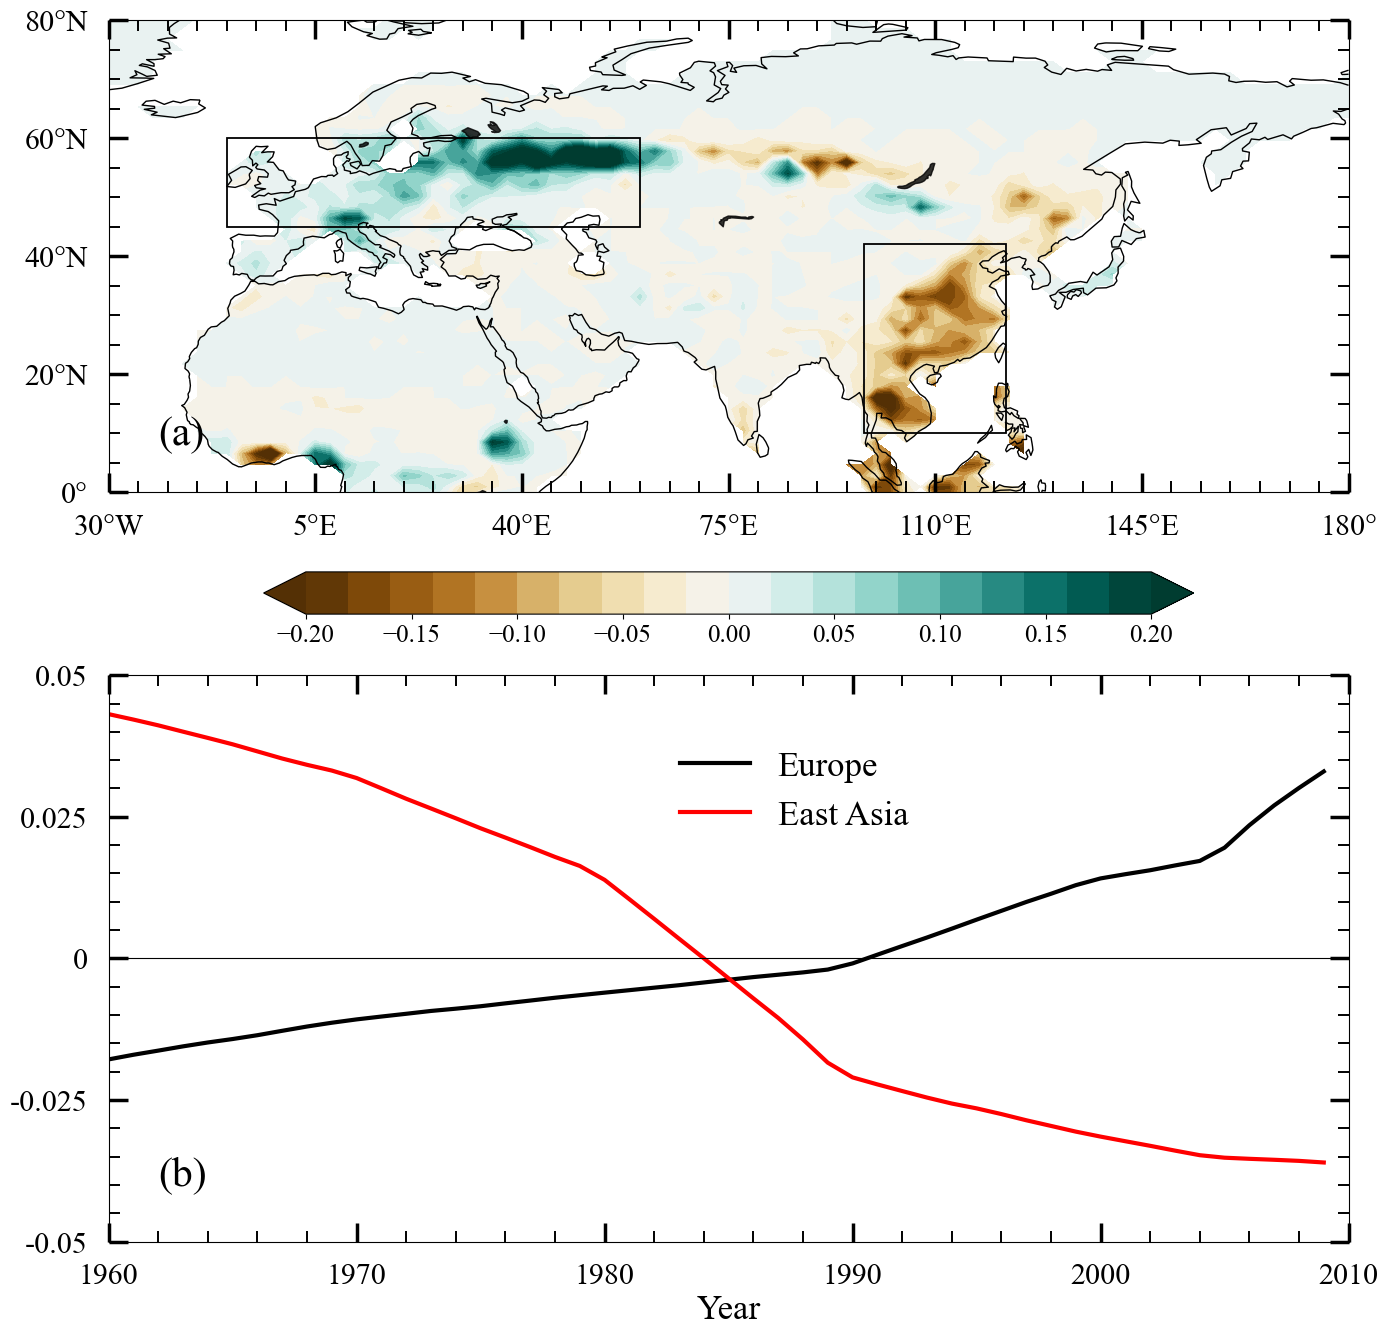

In [23]:
lonmin, lonmax = -30., 180.
latmin, latmax = 0., 80.
lon, lat = ds['lon'].values, ds['lat'].values
lai_mean_nan = np.where(land > 0.3, lai_diff, np.nan)
cycle_lai_mean, cycle_lon = add_cyclic_point(lai_mean_nan, coord=lon)
cycle_lon, cycle_lat = np.meshgrid(cycle_lon, lat)
fig = plt.figure(figsize=(16, 16))
gs = gridspec.GridSpec(39, 1)
gs.update(wspace=0.26, hspace=0.15)
ax = fig.add_subplot(gs[0:21, 0], projection=ccrs.PlateCarree(central_longitude=80))
ax.set_extent([lonmin, lonmax, latmin, latmax], crs=ccrs.PlateCarree())
# normzj = mpl.colors.Normalize(vmin=0, vmax=3)
# c1 = ax.contourf(cycle_lon, cycle_lat, cycle_lai_mean, cmap='YlGn', levels=np.arange(0, 3.1, 0.1), extend='both', transform=ccrs.PlateCarree())
c1 = ax.contourf(cycle_lon, cycle_lat, cycle_lai_mean, cmap='BrBG', levels=np.arange(-0.2, 0.21, 0.02), extend='both', transform=ccrs.PlateCarree())
# c1 = ax.contourf(cycle_lon, cycle_lat, cycle_lai_mean, cmap='BrBG', levels=np.arange(-0.005, 0.0051, 0.0004), extend='both', transform=ccrs.PlateCarree())
cbar = fig.colorbar(c1, orientation='horizontal', shrink=0.75, pad=0.12)
tick=np.arange(-0.2, 0.21, 0.05)
cbar.set_ticks(ticks=tick)
ax.add_feature(cfeat.COASTLINE)
ax.add_feature(cfeat.LAKES, color='black', alpha=0.8)
ax.set_xticks([-30, 5, 40, 75, 110, 145, 180], crs=ccrs.PlateCarree())
ax.set_yticks([0, 20, 40, 60, 80], crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
ax.tick_params(axis="both", which='major', width=2.5, length=14, direction='in', right=True, top=True, pad=15)
ax.tick_params(axis="both", which='minor', width=1.4, length=8, direction='in', right=True, top=True)
ax.tick_params(tick2On=True, label2On=False)
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(5))
ax.tick_params(axis='both', labelsize='large')
lonL_EU, lonR_EU = -10, 60.
latS_EU, latN_EU = 45, 60.
lonL_EA, lonR_EA = 98, 122.
latS_EA, latN_EA = 10, 42.
rect1 = mpl.patches.Rectangle((lonL_EU, latS_EU), lonR_EU-lonL_EU, latN_EU-latS_EU, linestyle = '-', fill=False, edgecolor = 'black', linewidth = 1.3, zorder = 5,transform=ccrs.PlateCarree())
rect2 = mpl.patches.Rectangle((lonL_EA, latS_EA), lonR_EA-lonL_EA, latN_EA-latS_EA, linestyle = '-', fill=False, edgecolor = 'black', linewidth = 1.3, zorder = 5,transform=ccrs.PlateCarree())
ax.add_patch(rect1)
ax.add_patch(rect2)
plt.text(0.04, 0.1, f'(a)', fontsize=30, transform=ax.transAxes)



yr = np.arange(1960, 2010, 1)
xmin, xmax = 1960., 2010.
ymin, ymax = -0.05, 0.05
ax2 = fig.add_subplot(gs[21:, 0])
ax2.plot(yr, lai_eu_ano, label='Europe', color='black', linewidth=3)
ax2.plot(yr, lai_ea_ano, label='East Asia', color='red', linewidth=3)
ax2.axhline(0, linewidth=0.8, color='black')
# ax2.axvline(1960, linewidth=0.6, color='grey', linestyle=(0,(15,8)))
ax2.set_xlim(xmin, xmax)
ax2.set_ylim(ymin, ymax)
ax2.set_xticks(np.arange(1960, 2011, 10))
ax2.set_yticks(np.arange(-0.05, 0.051, 0.025))
ax2.set_yticklabels(['-0.05', '-0.025', '0', '0.025', '0.05'])
ax2.set_xlabel('Year', fontsize=25)
ax2.legend(loc=(0.45, 0.7), frameon=False, fontsize=25)
ax2.tick_params(axis="both", which='major', width=2.5, length=14, direction='in', right=True, top=True, pad=15)
ax2.tick_params(axis="both", which='minor', width=1.4, length=8, direction='in', right=True, top=True)
ax2.tick_params(tick2On=True, label2On=False)
ax2.xaxis.set_minor_locator(MultipleLocator(2))
ax2.yaxis.set_minor_locator(MultipleLocator(0.005))
ax2.tick_params(axis='both', labelsize='large')
plt.text(0.04, 0.1, f'(b)', fontsize=30, transform=ax2.transAxes)
plt.savefig(f'F:\\hwchen\\lai_practice\\picture\\lai.png', bbox_inches='tight')